In [232]:
import pyro
import pyro.infer
import pyro.optim
import pyro.distributions as dist
import torch.distributions.constraints as constraints
import torch
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
print(pyro.__version__)

0.3.1


From the graph we can write out the full joint as

$$ p(l, t, p, \tilde{A}; \mu_t,\sigma_t,\mu_p,\sigma_p) = p(p)*\prod_{i=1}^N p(t_i) * p(l_i \mid \tilde{A}_i) p(\tilde{A}_i \mid t_i,p) $$

where $l$ is the likesMovie, $t$ is the trait, $p$ is the preferance, $\tilde{A}$ is the noisyAffinity

In [95]:
def model_multi_movies(y):
    mean_pref = torch.tensor(0.)
    std_pref = torch.tensor(1.)
    pref = pyro.sample("pref",dist.Normal(mean_pref,std_pref))

    mean_trait = torch.tensor(0.)
    std_trait = torch.tensor(1.)
    
    known_trait = pyro.sample("known_trait", dist.Normal(mean_trait, std_trait), obs = torch.tensor(1.))
    noisy_affinity = pyro.sample('noisy_affinity_0', dist.Normal(known_trait*pref,torch.tensor(0.2)))
    likes_movie = pyro.sample('likes_movie_0',dist.Bernoulli(torch.sigmoid(noisy_affinity)), obs=y[0])

    with pyro.plate("movies", len(y)-1):
        trait = pyro.sample("trait", dist.Normal(mean_trait,std_trait))
        noisy_affinity = pyro.sample('noisy_affinity'.format(i+1), dist.Normal(trait*pref,torch.tensor(0.2)))
        likes_movie = pyro.sample('likes_movie',dist.Bernoulli(torch.sigmoid(noisy_affinity)), obs=y[1:])

def guide(y):
    mean_pref = pyro.param("mean_pref",torch.tensor(10.0))
    std_pref = pyro.param("std_pref",torch.tensor(1.0),constraint=constraints.positive)
    pref = pyro.sample("pref",dist.Normal(mean_pref,std_pref))
    mean_trait = pyro.param("mean_trait", torch.zeros(len(y)-1))
    std_trait = pyro.param("std_trait", torch.ones(len(y)-1),constraint=constraints.positive) 
    
    with pyro.plate("movies", len(y)-1):
        trait = pyro.sample("trait" ,dist.Normal(mean_trait,std_trait))


..............................

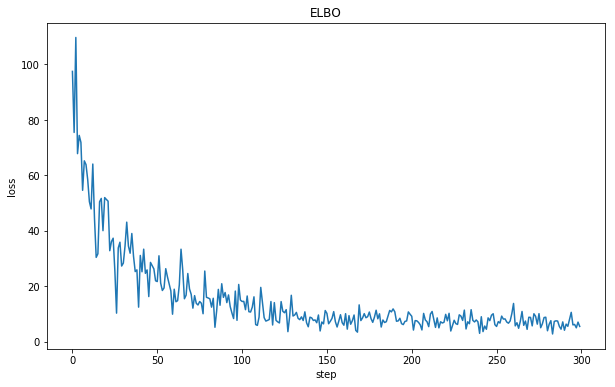

In [40]:
# fake data
y_temp = np.array([1 if(i%2==0) else 0 for i in range(0, 10)])
y = torch.Tensor(y_temp.astype(np.float32))
# print(y)

pyro.clear_param_store()
svi = pyro.infer.SVI(model=model_multi_movies,
                     guide=guide,
                     optim=pyro.optim.SGD({"lr": 0.01, "momentum":0.001}),
                     loss=pyro.infer.Trace_ELBO())
losses =[]

num_steps = 300
for i in range(num_steps):
    losses.append(svi.step(y))
    if(i%10==0):
        print(".", end='')
        
plt.figure(figsize=(10,6))    
plt.plot(losses)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss")
plt.show()

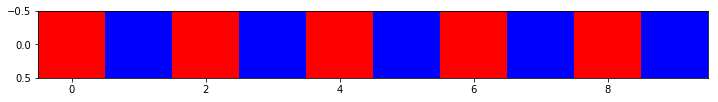

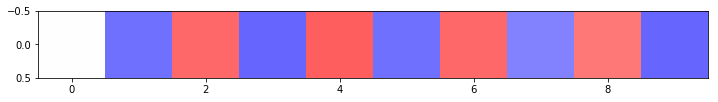

tensor([ 0.0000, -0.5566,  0.5918, -0.5951,  0.6315, -0.5582,  0.5880, -0.4882,
         0.5256, -0.5966])

In [60]:
plt.figure(figsize=(12,3)) 
y[y==0]=-1
plt.imshow(y[1:].reshape((1,9)), cmap='bwr', vmin=-1., vmax=1.)
plt.show()

testing_values = pyro.param("mean_pref").data.mul( pyro.param("mean_trait").data )
plt.figure(figsize=(12,3)) 
plt.imshow(testing_values.reshape((1,9)), cmap='bwr', vmin=-1., vmax=1.)
plt.show()
testing_values


In [126]:
def model_multi_people(y, num_traits):
    num_people, num_movies = y.shape
    mean_pref = torch.tensor(0.)
    std_pref = torch.tensor(1.)
    mean_trait = torch.tensor(0.)
    std_trait = torch.tensor(1.)
    
    with pyro.plate("traits", num_traits):
        with pyro.plate("people", num_people):
            pref = pyro.sample("pref",dist.Normal(mean_pref,std_pref))
        with pyro.plate("movies", num_movies - num_traits):
            trait = pyro.sample("trait", dist.Normal(mean_trait,std_trait))
    
    known_trait = pyro.sample("known_trait", dist.Normal(mean_trait, std_trait), obs = torch.eye(num_traits))
    known_affinity = torch.mm(pref, known_trait.transpose(0,1))
    known_noisy_affinity = pyro.sample('known_noisy_affinity', dist.Normal(known_affinity,torch.tensor(0.2)))
    known_likes_movie = pyro.sample('known_likes_movie',dist.Bernoulli(torch.sigmoid(known_noisy_affinity)), obs=y[:,:num_traits])
    
    affinity = torch.mm(pref, trait.transpose(0,1))
    noisy_affinity = pyro.sample('noisy_affinity', dist.Normal(affinity, torch.tensor(0.2)))
    likes_movie = pyro.sample('likes_movie',dist.Bernoulli(torch.sigmoid(noisy_affinity)), obs=y[:,num_traits:])
    
def guide(y, num_traits):
    num_people, num_movies = y.shape
    
    mean_pref = pyro.param("mean_pref", torch.zeros(num_people, num_traits)+5)
    std_pref = pyro.param("std_pref", torch.ones(num_people, num_traits))
    mean_trait = pyro.param("mean_trait", torch.zeros(num_movies-num_traits,num_traits)+5)
    std_trait = pyro.param("std_trait", torch.ones(num_movies-num_traits,num_traits))
    # each movie and person should have their own distribution, so the following is wrong
#     mean_pref = pyro.param("mean_pref", torch.tensor(10.))
#     std_pref = pyro.param("std_pref", torch.tensor(1.))
#     mean_trait = pyro.param("mean_trait", torch.tensor(10.))
#     std_trait = pyro.param("std_trait", torch.tensor(1.))
    
    with pyro.plate("traits", num_traits):
        with pyro.plate("people", num_people):
            pref = pyro.sample("pref",dist.Normal(mean_pref,std_pref))
        with pyro.plate("movies", num_movies - num_traits):
            trait = pyro.sample("trait", dist.Normal(mean_trait,std_trait))

def check_accuracy(y):
    testing_values = torch.mm(pyro.param("mean_pref").data,pyro.param("mean_trait").data.transpose(0,1))
    testing_result = torch.sign(testing_values)
    testing_result[testing_result==-1]=0.
#     print('testing_result\n',testing_result)
#     print('truth\n',y[:,num_traits:])
    a,b = testing_result.shape
    return torch.sum(testing_result == y[:,num_traits:]).float()/(a*b)
def check_accuracy_sampling(y):
    pref = pyro.sample("pref",dist.Normal(pyro.param("mean_pref").data, pyro.param("std_pref").data))
    trait = pyro.sample("trait",dist.Normal(pyro.param("mean_trait").data, pyro.param("std_trait").data))
    
    testing_values = torch.mm(pref, trait.data.transpose(0,1))
    testing_result = torch.sign(testing_values)
    testing_result[testing_result==-1]=0.
#     print('testing_result\n',testing_result)
#     print('truth\n',y[:,num_traits:])
    a,b = testing_result.shape
    return torch.sum(testing_result == y[:,num_traits:]).float()/(a*b)


..................................................

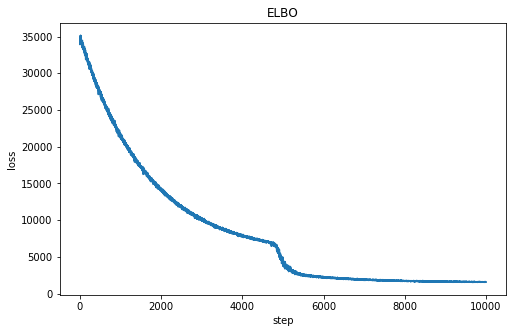

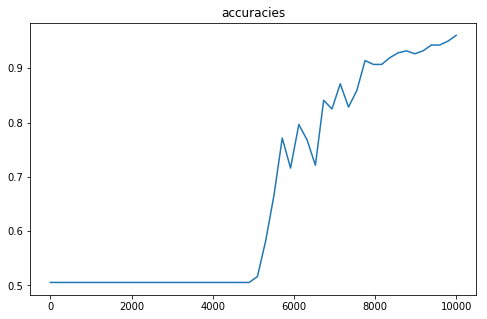

In [127]:
# generate fake data  (num_people, num_movies)
y = torch.randint(2, size = (8,100)).float()
# print('fake data\n',y)

pyro.clear_param_store()
svi = pyro.infer.SVI(model=model_multi_people,
                     guide=guide,
                     optim=pyro.optim.SGD({"lr": 0.0003, "momentum":0.0002}),
                     loss=pyro.infer.Trace_ELBO())
losses =[]
accuracies =[]
num_steps = 10000
num_traits = 30
for i in range(num_steps):
    losses.append(svi.step(y, num_traits))
    if(i%200==0):
        accuracies.append(check_accuracy(y) )
        print(".", end='')
        
plt.figure(figsize=(8,5))    
plt.plot(losses)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss")
plt.show()
plt.figure(figsize=(8,5))    
plt.plot(np.linspace(0,num_steps,len(accuracies)),accuracies)
plt.title("accuracies")
plt.show()

In [128]:
check_accuracy(y)

tensor(0.9679)

In [129]:
check_accuracy_sampling(y)

tensor(0.6536)

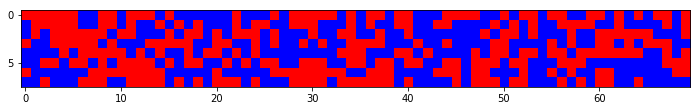

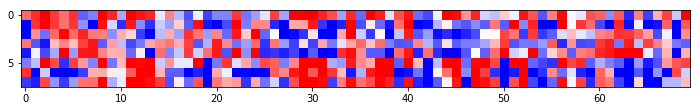

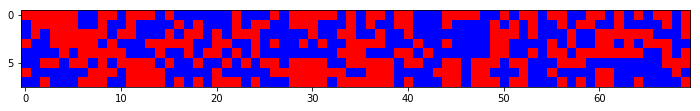

In [130]:
plt.figure(figsize=(12,3)) 
y[y==0]=-1
plt.imshow(y[:,num_traits:], cmap='bwr', vmin=-1., vmax=1.)
plt.show()

testing_values = torch.mm(pyro.param("mean_pref").data,pyro.param("mean_trait").data.transpose(0,1))
plt.figure(figsize=(12,3)) 
plt.imshow(testing_values, cmap='bwr', vmin=-1., vmax=1.)
plt.show()

testing_result = torch.sign(testing_values)
plt.figure(figsize=(12,3)) 
plt.imshow(testing_result, cmap='bwr', vmin=-1., vmax=1.)
plt.show()

In [382]:
def model_with_mask(y, num_traits):
    num_people, num_movies = y.shape
    mean_pref = torch.tensor(0.)
    std_pref = torch.tensor(1.)
    mean_trait = torch.tensor(0.)
    std_trait = torch.tensor(1.)
    
    with pyro.plate("traits", num_traits):
        with pyro.plate("people", num_people):
            pref = pyro.sample("pref",dist.Normal(mean_pref,std_pref))
        with pyro.plate("movies", num_movies - num_traits):
            trait = pyro.sample("trait", dist.Normal(mean_trait,std_trait))
    
    known_trait = pyro.sample("known_trait", dist.Normal(mean_trait, std_trait), obs = torch.eye(num_traits))
    known_affinity = torch.mm(pref, known_trait.transpose(0,1))
    known_noisy_affinity = pyro.sample('known_noisy_affinity', dist.Normal(known_affinity,torch.tensor(0.2)))
    is_observed = (y[:,:num_traits] != -1)
    with pyro.poutine.mask(mask=is_observed):
        known_likes_movie = pyro.sample('known_likes_movie',dist.Bernoulli(torch.sigmoid(known_noisy_affinity)), obs=y[:,:num_traits])
    
    affinity = torch.mm(pref, trait.transpose(0,1))
    noisy_affinity = pyro.sample('noisy_affinity', dist.Normal(affinity, torch.tensor(0.2)))
    
    is_observed = (y[:,num_traits:] != -1)
    with pyro.poutine.mask(mask=is_observed):
        likes_movie = pyro.sample('likes_movie',dist.Bernoulli(torch.sigmoid(noisy_affinity)), obs=y[:,num_traits:])
    
def guide(y, num_traits):
    num_people, num_movies = y.shape
    
    mean_pref = pyro.param("mean_pref", torch.zeros(num_people, num_traits)+2)
    std_pref = pyro.param("std_pref", torch.ones(num_people, num_traits))
    mean_trait = pyro.param("mean_trait", torch.zeros(num_movies-num_traits,num_traits)+2)
    std_trait = pyro.param("std_trait", torch.ones(num_movies-num_traits,num_traits))
    # each movie and person should have their own distribution, so the following is wrong
#     mean_pref = pyro.param("mean_pref", torch.tensor(10.))
#     std_pref = pyro.param("std_pref", torch.tensor(1.))
#     mean_trait = pyro.param("mean_trait", torch.tensor(10.))
#     std_trait = pyro.param("std_trait", torch.tensor(1.))
    
    with pyro.plate("traits", num_traits):
        with pyro.plate("people", num_people):
            pref = pyro.sample("pref",dist.Normal(mean_pref,std_pref))
        with pyro.plate("movies", num_movies - num_traits):
            trait = pyro.sample("trait", dist.Normal(mean_trait,std_trait))



....................................................................................................

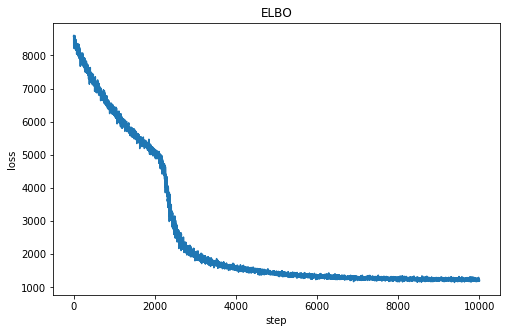

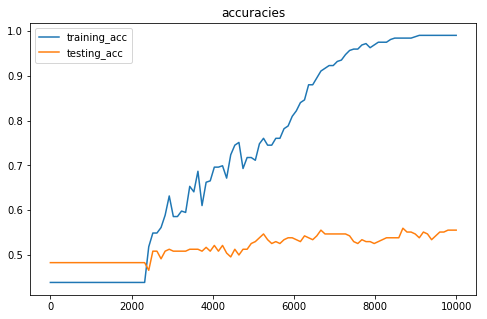

In [384]:
# generate fake data  (num_people, num_movies)
y_truth = torch.randint(2, size = (8,100)).float()
y = y_truth.clone()
for i in range(8):
    missing_index = np.random.choice(np.arange(0,100), replace=False, size=np.random.randint(low=30, high=50))
    for index in missing_index:
        y[i, index] = -1.

y_which_missing = torch.zeros_like(y)
y_which_missing[y==-1]=1.

y_truth_01 = torch.clone(y_truth)
y_truth_01[y_truth==0]=-1

# print('fake data\n',y)

pyro.clear_param_store()
svi = pyro.infer.SVI(model=model_with_mask,
                     guide=guide,
                     optim=pyro.optim.SGD({"lr": 0.0003, "momentum":0.0002}),
                     loss=pyro.infer.Trace_ELBO())
losses =[]
training_acc =[]
testing_acc =[]

num_steps = 10000
num_traits = 30
for i in range(num_steps):
    losses.append(svi.step(y, num_traits))
    if(i%100==0):
        testing_values = torch.mm(pyro.param("mean_pref").data, pyro.param("mean_trait").data.transpose(0,1))
        total = torch.sum(y_which_missing[:,num_traits:])
        count = torch.sum(y_which_missing[:,num_traits:]*(y_truth_01[:,num_traits:] == torch.sign(testing_values)).float())
        testing_acc.append(count/total)
        total = torch.sum(y_which_missing[:,num_traits:]-1)
        count = torch.sum((y_which_missing[:,num_traits:]-1)*(y_truth_01[:,num_traits:] == torch.sign(testing_values)).float())
        training_acc.append(count/total)
        print(".", end='')
        
plt.figure(figsize=(8,5))    
plt.plot(losses)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss")
plt.show()
plt.figure(figsize=(8,5))    
plt.plot(np.linspace(0,num_steps,len(training_acc)), training_acc, label='training_acc')
plt.plot(np.linspace(0,num_steps,len(testing_acc)), testing_acc, label='testing_acc')
plt.title("accuracies")
plt.legend()
plt.show()


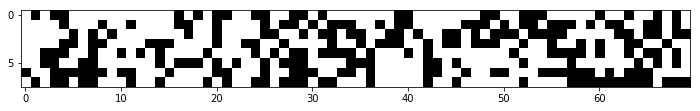

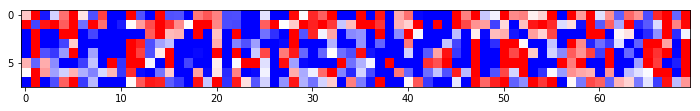

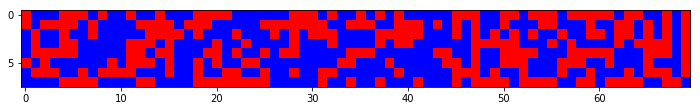

In [385]:
testing_values = torch.mm(pyro.param("mean_pref").data,pyro.param("mean_trait").data.transpose(0,1))

plt.figure(figsize=(12,3)) 
plt.imshow(y_which_missing[:,num_traits:], cmap='binary', vmin=0, vmax=1.)
plt.show()

plt.figure(figsize=(12,3)) 
plt.imshow(testing_values, cmap='bwr', vmin=-1., vmax=1.)
plt.show()

plt.figure(figsize=(12,3)) 
plt.imshow(y_truth_01[:,num_traits:], cmap='bwr', vmin=-1., vmax=1.)
plt.show()


In [376]:
testing_values = torch.mm(pyro.param("mean_pref").data,pyro.param("mean_trait").data.transpose(0,1))
# testing error
total = torch.sum(y_which_missing[:,num_traits:])
count = torch.sum(y_which_missing[:,num_traits:]*(y_truth_01[:,num_traits:] == torch.sign(testing_values)).float())
print('testing acc',count/total)
# training error
total = torch.sum(y_which_missing[:,num_traits:]-1)
count = torch.sum((y_which_missing[:,num_traits:]-1)*(y_truth_01[:,num_traits:] == torch.sign(testing_values)).float())
print('training acc',count/total)


testing acc tensor(0.9576)
training acc tensor(0.9537)


In [315]:
ratings = pd.read_csv('/Users/joey/github/MBML-seminar/ml-latest-small/ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [392]:
'''
loading and processing real data
the matrix is 610 by 9724.
'''

# ratings = pd.read_csv('/Users/joey/github/MBML-seminar/ml-latest-small/ratings.csv')
# person_index = list(ratings['userId'].value_counts().keys())
# movie_index = list(ratings['movieId'].value_counts().keys())

# num_of_users = len(person_index)
# num_of_movies = len(movie_index)

# ratings = ratings.values[:,:3]

# mat  = -1.0* np.ones((num_of_users, num_of_movies), dtype=int)
# for idx, rate in enumerate(ratings):
#     if(idx%1000 == 0):
#         print(".", end='')
#     row = person_index.index(rate[0])
#     col = movie_index.index(rate[1])
#     if rate[2] > 3:  
#         mat[row][col] = 1.
#     else:
#         mat[row][col] = 0.

# data = torch.tensor(mat).float()
# torch.save(data, 'data.pt')
data_truth = torch.load('data.pt').float()
     

In [482]:
# adding self-made mask
num_people = 8
num_movies = 100
data = data_truth[:num_people,:num_movies].clone()
data_real_missing = torch.zeros_like(data_truth[:num_people,:num_movies])
data_real_missing[data_truth[:num_people,:num_movies]==-1]=1.

for i in range(num_people):
    missing_index = np.random.choice(np.arange(0,num_movies), replace=False, size=np.random.randint(low=15, high=25))
    for index in missing_index:
        data[i, index] = -1.

data_which_missing = torch.zeros_like(data)
data_which_missing[data==-1] = 1.

data_truth_01 = data_truth[:num_people,:num_movies].clone()
data_truth_01[data_truth[:num_people,:num_movies]==0] = -1
data_truth_01[data_truth[:num_people,:num_movies]==-1] = -2



....................................................................................................

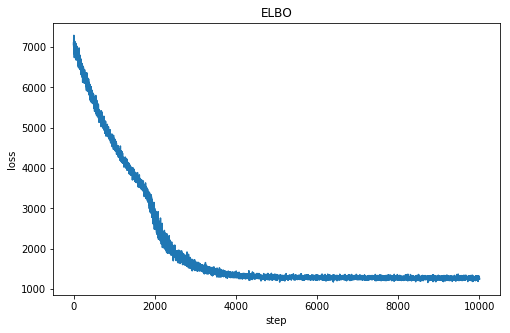

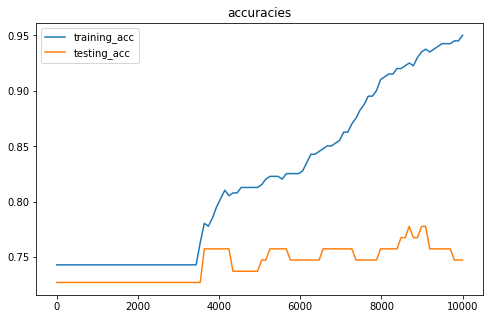

In [483]:
pyro.clear_param_store()
svi = pyro.infer.SVI(model=model_with_mask,
                     guide=guide,
                     optim=pyro.optim.Adam({"lr": 0.0008, "betas": (0.90, 0.999)}),
#                      optim=pyro.optim.SGD({"lr": 0.0001, "momentum":0.0003}),
                     loss=pyro.infer.Trace_ELBO())
losses =[]
training_acc = []
testing_acc = []
num_steps = 10000
num_traits = 30
for i in range(num_steps):
    losses.append(svi.step(data, num_traits))
    if(i%100==0):
        testing_values = torch.mm(pyro.param("mean_pref").data, pyro.param("mean_trait").data.transpose(0,1))
        total = torch.sum(data_which_missing[:,num_traits:]!=data_real_missing[:,num_traits:])
        count = torch.sum((data_which_missing[:,num_traits:]!=data_real_missing[:,num_traits:]).float()*(data_truth_01[:,num_traits:] == torch.sign(testing_values)).float())
        testing_acc.append(count/total)
        total = torch.sum(data_which_missing[:,num_traits:]-1)
        count = torch.sum((data_which_missing[:,num_traits:]-1)*(data_truth_01[:,num_traits:] == torch.sign(testing_values)).float())
        training_acc.append(count/total)
        print(".", end='')
        
plt.figure(figsize=(8,5))    
plt.plot(losses)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss")
plt.show()

plt.figure(figsize=(8,5))    
plt.plot(np.linspace(0,num_steps,len(training_acc)), training_acc, label='training_acc')
plt.plot(np.linspace(0,num_steps,len(testing_acc)), testing_acc, label='testing_acc')
plt.title("accuracies")
plt.legend()
plt.show()

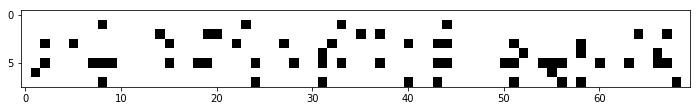

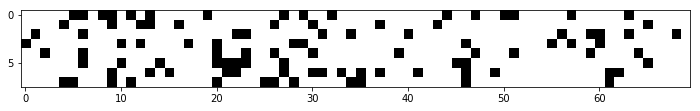

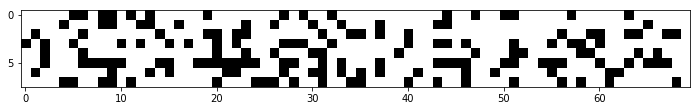

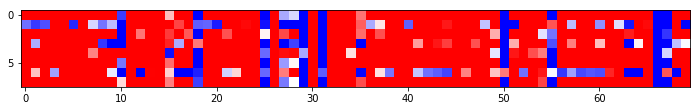

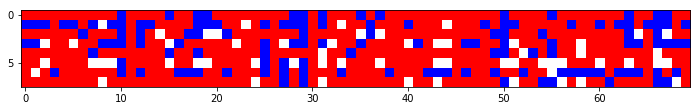

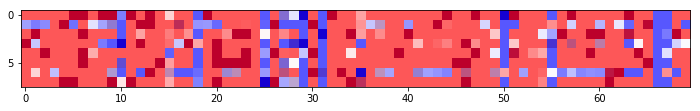

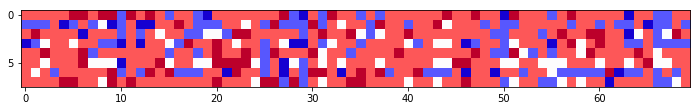

In [484]:
testing_values = torch.mm(pyro.param("mean_pref").data,pyro.param("mean_trait").data.transpose(0,1))

plt.figure(figsize=(12,3)) 
plt.imshow(data_real_missing[:,num_traits:], cmap='binary', vmin=0, vmax=1.)
plt.show()


plt.figure(figsize=(12,3)) 
plt.imshow((data_which_missing[:,num_traits:]!=data_real_missing[:,num_traits:]).float(), cmap='binary', vmin=0, vmax=1.)
plt.show()

plt.figure(figsize=(12,3)) 
plt.imshow(data_which_missing[:,num_traits:], cmap='binary', vmin=0, vmax=1.)
plt.show()

plt.figure(figsize=(12,3)) 
plt.imshow(testing_values, cmap='bwr', vmin=-1., vmax=1.)
plt.show()

data_truth_02 = data_truth[:num_people,:num_movies].clone()
data_truth_02[data_truth[:num_people,:num_movies]==0] = -1
data_truth_02[data_truth[:num_people,:num_movies]==-1] = 0

plt.figure(figsize=(12,3)) 
plt.imshow(data_truth_02[:num_people,:num_movies][:,num_traits:], cmap='bwr', vmin=-1., vmax=1.)
plt.show()

# I cover the second image onto 4th and 5th, 
# so that if the pixel is shaded, it means it comes from testing set
plt.figure(figsize=(12,3)) 
plt.imshow(testing_values, cmap='bwr', vmin=-1., vmax=1.)
plt.imshow((data_which_missing[:,num_traits:]!=data_real_missing[:,num_traits:]).float(), cmap='Purples', alpha = 0.35, vmin=0, vmax=1.)
plt.show()

plt.figure(figsize=(12,3)) 
plt.imshow(data_truth_02[:num_people,:num_movies][:,num_traits:], cmap='bwr', vmin=-1., vmax=1.)
plt.imshow((data_which_missing[:,num_traits:]!=data_real_missing[:,num_traits:]).float(), cmap='Purples', alpha = 0.35, vmin=0, vmax=1.)
plt.show()


In [491]:
confusion_train = np.zeros((2,2))
confusion_test = np.zeros((2,2))
for i in range(num_people):
    for j in range(num_movies-num_traits):
        if data_real_missing[i,j+num_traits] != 1:
            if data_which_missing[i,j+num_traits]!=data_real_missing[i,j+num_traits]: # testing set
                if data_truth[i,j+num_traits] == 1 and torch.sign(testing_values[i,j]).float() == 1:
                    confusion_test[0,0] = confusion_test[0,0] + 1
                elif data_truth[i,j+num_traits] == 1 and torch.sign(testing_values[i,j]).float() == -1:
                    confusion_test[1,0] = confusion_test[1,0] + 1
                elif data_truth[i,j+num_traits] == 0 and torch.sign(testing_values[i,j]).float() == 1:
                    confusion_test[0,1] = confusion_test[0,1] + 1
                elif data_truth[i,j+num_traits] == 0 and torch.sign(testing_values[i,j]).float() == -1:
                    confusion_test[1,1] = confusion_test[1,1] + 1
            else: # training set
                if data_truth[i,j+num_traits] == 1 and torch.sign(testing_values[i,j]).float() == 1:
                    confusion_train[0,0] = confusion_train[0,0] + 1
                elif data_truth[i,j+num_traits] == 1 and torch.sign(testing_values[i,j]).float() == -1:
                    confusion_train[1,0] = confusion_train[1,0] + 1
                elif data_truth[i,j+num_traits] == 0 and torch.sign(testing_values[i,j]).float() == 1:
                    confusion_train[0,1] = confusion_train[0,1] + 1
                elif data_truth[i,j+num_traits] == 0 and torch.sign(testing_values[i,j]).float() == -1:
                    confusion_train[1,1] = confusion_train[1,1] + 1


In [492]:
print('confusion matrix of training set\n',confusion_train)
print('confusion matrix of testing set\n',confusion_test)

confusion matrix of training set
 [[293.  15.]
 [  5.  88.]]
confusion matrix of testing set
 [[64. 17.]
 [ 8. 10.]]


In [497]:
testing_values = torch.mm(pyro.param("mean_pref").data, pyro.param("mean_trait").data.transpose(0,1))
total = torch.sum(data_which_missing[:,num_traits:]!=data_real_missing[:,num_traits:])
count = torch.sum((data_which_missing[:,num_traits:]!=data_real_missing[:,num_traits:]).float()*(data_truth_01[:,num_traits:] == torch.sign(testing_values)).float())
print('testing acc', count/total)
total = torch.sum(data_which_missing[:,num_traits:]-1)
count = torch.sum((data_which_missing[:,num_traits:]-1)*(data_truth_01[:,num_traits:] == torch.sign(testing_values)).float())
training_acc.append(count/total)
print('training acc',count/total)


testing acc tensor(0.7475)
training acc tensor(0.9501)


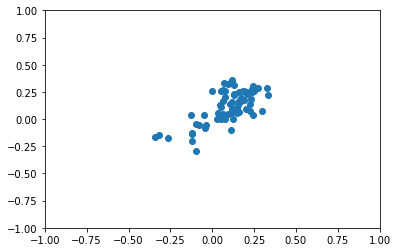

In [513]:
plt.scatter(pyro.param("mean_trait").data[:,0],pyro.param("mean_trait").data[:,1])
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.show()

In [521]:
from sklearn.decomposition import PCA
pca = PCA(n_components=5)
pca_points = pca.fit_transform(pyro.param("mean_trait").data)
print(pca.singular_values_)

[7.40562344 4.92657027 4.52501208 2.95756663 1.97376459]


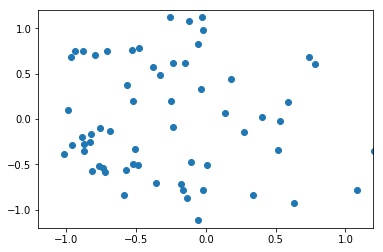

In [516]:
plt.scatter(pca_points[:,0],pca_points[:,1])
plt.xlim(-1.2,1.2)
plt.ylim(-1.2,1.2)
plt.show()

# model with stars(not working)

In [560]:
ratings = pd.read_csv('/Users/joey/github/MBML-seminar/ml-latest-small/ratings.csv')
set(ratings['rating'])


{0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0}

In [561]:
person_index = list(ratings['userId'].value_counts().keys())
movie_index = list(ratings['movieId'].value_counts().keys())

num_of_users = len(person_index)
num_of_movies = len(movie_index)

ratings = ratings.values[:,:3]

mat  = np.zeros((num_of_users, num_of_movies))
for idx, rate in enumerate(ratings):
    if(idx%1000 == 0):
        print(".", end='')
    row = person_index.index(rate[0])
    col = movie_index.index(rate[1])
    mat[row][col] = rate[2]

data_truth = torch.tensor(mat)
torch.save(data_truth, 'data_ratings.pt')
# data_truth = torch.load('data_ratings.pt').float()


.....................................................................................................

In [605]:
data_truth[:10,:10].float()

tensor([[5.0000, 5.0000, 5.0000, 4.0000, 5.0000, 5.0000, 4.0000, 5.0000, 5.0000,
         4.0000],
        [3.5000, 4.0000, 5.0000, 3.0000, 5.0000, 5.0000, 4.0000, 3.5000, 4.5000,
         0.0000],
        [3.0000, 5.0000, 4.0000, 4.5000, 4.5000, 4.0000, 4.5000, 3.0000, 4.0000,
         5.0000],
        [3.0000, 0.0000, 5.0000, 5.0000, 2.0000, 5.0000, 3.0000, 0.0000, 3.0000,
         0.0000],
        [4.5000, 4.5000, 5.0000, 4.0000, 4.0000, 3.0000, 3.5000, 4.5000, 4.5000,
         4.0000],
        [3.0000, 3.0000, 5.0000, 4.5000, 5.0000, 5.0000, 5.0000, 4.5000, 5.0000,
         3.5000],
        [3.5000, 3.0000, 2.0000, 3.5000, 4.5000, 5.0000, 3.5000, 2.5000, 3.5000,
         4.0000],
        [5.0000, 3.0000, 5.0000, 5.0000, 4.5000, 5.0000, 5.0000, 4.0000, 5.0000,
         0.0000],
        [4.0000, 3.5000, 5.0000, 4.5000, 5.0000, 4.5000, 2.5000, 3.5000, 3.5000,
         5.0000],
        [5.0000, 5.0000, 5.0000, 5.0000, 3.0000, 5.0000, 2.0000, 5.0000, 4.0000,
         5.0000]])

In [564]:
# adding self-made mask
num_people = 8
num_movies = 100
data = data_truth[:num_people,:num_movies].clone()
data_real_missing = torch.zeros_like(data_truth[:num_people,:num_movies])
data_real_missing[data_truth[:num_people,:num_movies]==0]=1.

for i in range(num_people):
    missing_index = np.random.choice(np.arange(0,num_movies), replace=False, size=np.random.randint(low=15, high=25))
    for index in missing_index:
        data[i, index] = 0.

data_which_missing = torch.zeros_like(data)
data_which_missing[data==0] = 1.

# data_truth_01 = data_truth[:num_people,:num_movies].clone()
# data_truth_01[data_truth[:num_people,:num_movies]==0] = -1
# data_truth_01[data_truth[:num_people,:num_movies]==-1] = -2


In [655]:
def model_with_star(y, num_traits):
    num_people, num_movies = y.shape
    mean_pref = torch.tensor(0.)
    std_pref = torch.tensor(1.)
    mean_trait = torch.tensor(0.)
    std_trait = torch.tensor(1.)
    mean_threshold = torch.tensor(0.)
    std_threshold = torch.tensor(1.)
    
    with pyro.plate("traits", num_traits):
        with pyro.plate("people", num_people):
            pref = pyro.sample("pref",dist.Normal(mean_pref,std_pref))
        with pyro.plate("movies", num_movies - num_traits):
            trait = pyro.sample("trait", dist.Normal(mean_trait,std_trait))
    with pyro.plate("stars", 8):
        threshold = pyro.sample("threshold",dist.Normal(mean_threshold, std_threshold))
    threshold_3star = pyro.sample("threshold_3star", dist.Normal(mean_threshold, std_threshold), obs = torch.tensor(0.))
    
    known_trait = pyro.sample("known_trait", dist.Normal(mean_trait, std_trait), obs = torch.eye(num_traits))
    known_affinity = torch.mm(pref, known_trait.transpose(0,1))
    known_noisy_affinity = pyro.sample('known_noisy_affinity', dist.Normal(known_affinity,torch.tensor(0.2)))
    
    a = torch.zeros_like(known_noisy_affinity)
    for i in torch.cat((threshold[:4], threshold_3star.reshape((1,)),threshold[4:]),0):
        a = a + 0.5*(known_noisy_affinity > i).float()
    is_observed = (y[:,:num_traits] != 0)
    with pyro.poutine.mask(mask=is_observed):
        known_has_star = pyro.sample('known_has_star',dist.Bernoulli(torch.sigmoid(a)), obs=y[:,:num_traits])
    
    affinity = torch.mm(pref, trait.transpose(0,1))
    noisy_affinity = pyro.sample('noisy_affinity', dist.Normal(affinity, torch.tensor(0.2)))
    
    a = torch.zeros_like(noisy_affinity)+0.5
    for i in torch.cat((threshold[:4], threshold_3star.reshape((1,)),threshold[4:]),0):
        a = a + 0.5*(noisy_affinity > i).float()
    is_observed = (y[:,num_traits:] != 0)
    with pyro.poutine.mask(mask=is_observed):
        has_star = pyro.sample('has_star',dist.Bernoulli(torch.sigmoid(a)), obs=y[:,num_traits:])
    
def guide(y, num_traits):
    num_people, num_movies = y.shape
    
    mean_pref = pyro.param("mean_pref", torch.zeros(num_people, num_traits)+2)
    std_pref = pyro.param("std_pref", torch.ones(num_people, num_traits))
    mean_trait = pyro.param("mean_trait", torch.zeros(num_movies-num_traits,num_traits)+2)
    std_trait = pyro.param("std_trait", torch.ones(num_movies-num_traits,num_traits))
    mean_threshold = pyro.param("mean_threshold", torch.arange(-4,5,1).float())
    mean_threshold = torch.cat([mean_threshold[0:4], mean_threshold[5:]])
    std_threshold = pyro.param("std_threshold", torch.ones(8)*5)
    
    with pyro.plate("traits", num_traits):
        with pyro.plate("people", num_people):
            pref = pyro.sample("pref",dist.Normal(mean_pref,std_pref))
        with pyro.plate("movies", num_movies - num_traits):
            trait = pyro.sample("trait", dist.Normal(mean_trait,std_trait))
    with pyro.plate("stars", 8):
        threshold = pyro.sample("threshold",dist.Normal(mean_threshold, std_threshold))


........................................................................................................................................................................................................

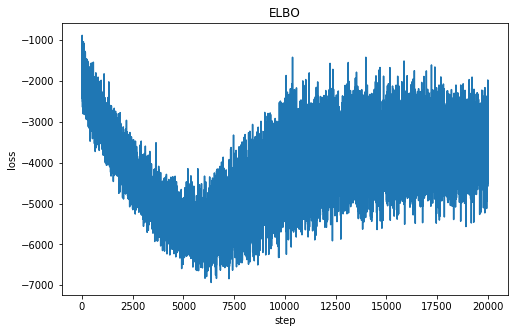

In [656]:
pyro.clear_param_store()
svi = pyro.infer.SVI(model=model_with_star,
                     guide=guide,
                     optim=pyro.optim.Adam({"lr": 0.0003, "betas": (0.90, 0.999)}),
#                      optim=pyro.optim.SGD({"lr": 0.0002, "momentum":0.0003}),
                     loss=pyro.infer.Trace_ELBO())
losses =[]
training_acc = []
testing_acc = []
num_steps = 20000
num_traits = 30
for i in range(num_steps):
    losses.append(svi.step(data.float(), num_traits))
    if(i%200==0):
#         testing_values = torch.mm(pyro.param("mean_pref").data, pyro.param("mean_trait").data.transpose(0,1))
#         total = torch.sum(data_which_missing[:,num_traits:]!=data_real_missing[:,num_traits:])
#         count = torch.sum((data_which_missing[:,num_traits:]!=data_real_missing[:,num_traits:]).float()*(data_truth_01[:,num_traits:] == torch.sign(testing_values)).float())
#         testing_acc.append(count/total)
#         total = torch.sum(data_which_missing[:,num_traits:]-1)
#         count = torch.sum((data_which_missing[:,num_traits:]-1)*(data_truth_01[:,num_traits:] == torch.sign(testing_values)).float())
#         training_acc.append(count/total)
        print(".", end='')
        
plt.figure(figsize=(8,5))    
plt.plot(losses)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss")
plt.show()


In [657]:
pyro.param("mean_threshold").data

tensor([-0.9076, -0.5711, -0.3625, -0.1649,  0.0000,  0.1588,  0.3699,  0.6026,
         0.9316])

In [658]:
testing_values

tensor([[0.0058, 0.0049, 0.0065, 0.0052, 0.0039, 0.0051, 0.0033, 0.0054, 0.0051,
         0.0070, 0.0067, 0.0049, 0.0058, 0.0053, 0.0052, 0.0042, 0.0053, 0.0047,
         0.0063, 0.0054, 0.0054, 0.0038, 0.0066, 0.0056, 0.0047, 0.0051, 0.0045,
         0.0056, 0.0082, 0.0059, 0.0071, 0.0052, 0.0062, 0.0052, 0.0058, 0.0057,
         0.0074, 0.0072, 0.0044, 0.0063, 0.0043, 0.0050, 0.0042, 0.0073, 0.0041,
         0.0053, 0.0045, 0.0058, 0.0045, 0.0070, 0.0041, 0.0065, 0.0087, 0.0078,
         0.0044, 0.0059, 0.0044, 0.0051, 0.0059, 0.0044, 0.0064, 0.0074, 0.0050,
         0.0067, 0.0071, 0.0083, 0.0036, 0.0048, 0.0070, 0.0053],
        [0.0044, 0.0067, 0.0064, 0.0049, 0.0067, 0.0051, 0.0045, 0.0058, 0.0067,
         0.0044, 0.0043, 0.0045, 0.0060, 0.0072, 0.0064, 0.0049, 0.0068, 0.0051,
         0.0068, 0.0055, 0.0067, 0.0039, 0.0062, 0.0074, 0.0041, 0.0039, 0.0058,
         0.0048, 0.0044, 0.0051, 0.0072, 0.0036, 0.0056, 0.0066, 0.0056, 0.0045,
         0.0071, 0.0072, 0.0064, 0.0069, 0.

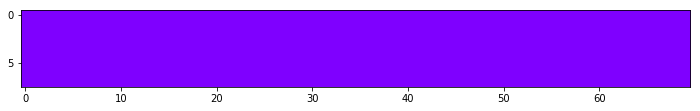

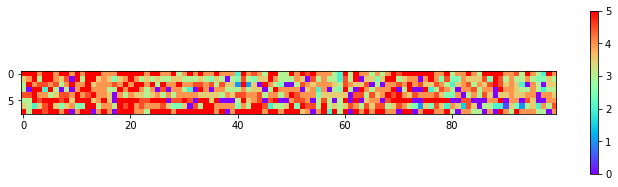

In [654]:
testing_values = torch.mm(pyro.param("mean_pref").data, pyro.param("mean_trait").data.transpose(0,1))

plt.figure(figsize=(12,3)) 
plt.imshow(testing_values, cmap='rainbow', vmin=0., vmax=5.)
plt.show()

plt.figure(figsize=(12,3)) 
plt.imshow(data_truth[:8,:100], cmap='rainbow', vmin=0., vmax=5.)
plt.colorbar()
plt.show()


# cells below are for testing

In [545]:
a = torch.zeros((2,3))+0.5
for i in torch.tensor([0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5]):
    a = a + 0.5*(torch.tensor([[1.2,0.1,3.1],[5.6,4.2,2.8]]) > i).float()
a

tensor([[1.5000, 0.5000, 3.5000],
        [5.0000, 4.5000, 3.0000]])

In [554]:
with pyro.plate("stars", 8):
    threshold = pyro.sample("threshold",dist.Normal(0., 1.))
threshold_3star = pyro.sample("threshold_3star", dist.Normal(0.1, 0.5), obs = torch.tensor(0.))
torch.cat((threshold[:4], threshold_3star.reshape((1,)),threshold[4:]),0)


/Users/joey/anaconda3/lib/python3.6/site-packages/pyro/primitives.py:71: RuntimeWarning: trying to observe a value outside of inference at threshold_3star
  RuntimeWarning)


tensor([ 0.5014, -1.6458,  0.0792, -0.2233,  0.0000,  0.9523,  0.3413, -1.6623,
         0.9642])

In [142]:
# testing 2 ways to write vecterized plate
with pyro.plate("people", 4):
    with pyro.plate('people_pref', 3):
        pref = pyro.sample("pref",dist.Normal(torch.zeros(3,4),torch.ones(3,4)))
print(pref)
with pyro.plate("people", 4):
    with pyro.plate('people_pref', 3):
        pref = pyro.sample("pref",dist.Normal(torch.tensor(0.),torch.tensor(1.)))
print(pref)

tensor([[ 0.8137, -0.1473,  0.1898,  0.2335],
        [ 0.5386,  1.3554,  0.1695, -0.1597],
        [-1.4589, -0.3568, -1.3960, -2.5034]])
tensor([[ 0.6719,  0.4003,  0.3866, -0.1909],
        [-0.6323,  0.0353,  2.2535,  0.8790],
        [-1.1479,  0.9909,  0.6656, -0.8265]])


In [143]:
# testing matrix multiplication
with pyro.plate("traits", 3):
    with pyro.plate("people", 2):
        pref = pyro.sample("pref",dist.Normal(torch.tensor(1.),torch.tensor(1.)))
    with pyro.plate("movies", 4):
        trait = pyro.sample("trait", dist.Normal(torch.tensor(1.),torch.tensor(1.)))
print(pref)
print(trait)
print(torch.mm(pref,trait.transpose(0,1)))

tensor([[0.5497, 1.0172, 1.5020],
        [0.0670, 0.6858, 2.5755]])
tensor([[ 0.8084,  3.0977,  0.7684],
        [ 1.2205,  0.0743, -0.0219],
        [ 1.1107,  0.4842,  0.3751],
        [ 1.4671,  1.4263,  0.5689]])
tensor([[4.7495, 0.7136, 1.6665, 3.1118],
        [4.1574, 0.0764, 1.3726, 2.5416]])


In [144]:
# testing obs
print(pyro.sample('likes_movie',dist.Bernoulli(torch.tensor(1.))))

print(pyro.sample('likes_movie',dist.Bernoulli(torch.tensor(1.)), obs=torch.ones(4,2)))


tensor(1.)
tensor([[1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.]])


/Users/joey/anaconda3/lib/python3.6/site-packages/pyro/primitives.py:71: RuntimeWarning: trying to observe a value outside of inference at likes_movie
  RuntimeWarning)
